## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.color import rgb2lab, lab2rgb
from matplotlib import patches as patch
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
import math
from numpy.linalg import inv, det
import scipy as sp
import seaborn as sns
from PIL import Image
from numpy.fft import rfft2, fft2, irfft2, ifft2,fftshift,ifftshift
from tqdm import tqdm
from skimage.feature import peak_local_max

%matplotlib inline

## Loading Test Image

In [2]:
img = Image.open("Picture1.png")
img = img.resize((size,size))
gray_image = img.convert('L')

NameError: name 'size' is not defined

## Defocus Kernel

In [5]:
size = 256

def defocus_kernel(d, sz=size):
    kern = np.zeros((sz, sz), np.uint8)
    cv2.circle(kern, (sz, sz), d, 255, -1, cv2.LINE_AA, shift=1)
    kern = np.float32(kern) / 255.0
    return kern

kernel = defocus_kernel(32, sz=size)


<function matplotlib.pyplot.show(close=None, block=None)>

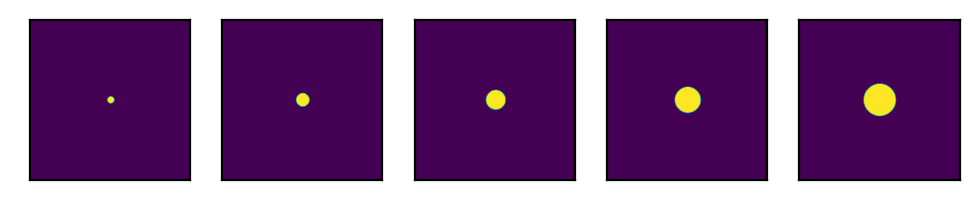

In [9]:
plt.figure(dpi = 200)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(defocus_kernel(10*(i+1), sz=size))
    plt.xticks([])
    plt.yticks([])
plt.show

## Gaussian Kernel

In [11]:
def Gauss(sigma):
    Gaussian = np.zeros([size,size], float)
    f = lambda x,y: np.exp(-(x*x+y*y)/(2*sigma*sigma))
    for i in range(size//2 + 1):
        for j in range(size//2 + 1):
            Gaussian[i,j]=f(i,j)
            Gaussian[-i,-j]=f(i,j)
            Gaussian[-i,j]=f(i,j)
            Gaussian[i,-j]=f(i,j)

    return fftshift(Gaussian)

<function matplotlib.pyplot.show(close=None, block=None)>

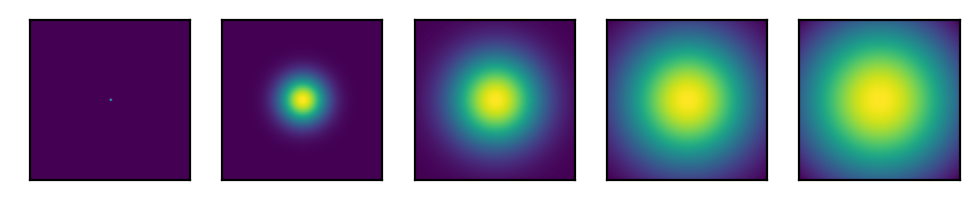

In [12]:
plt.figure(dpi = 200)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(Gauss(sigma = 25*i+1))
    plt.xticks([])
    plt.yticks([])
plt.show

# FFT Correlation

/var/folders/rk/gz59x8xx0bz69pn391mjkglw0000gn/T/ipykernel_3014/3621840046.py:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(fft_kernel)), cmap = cmap)


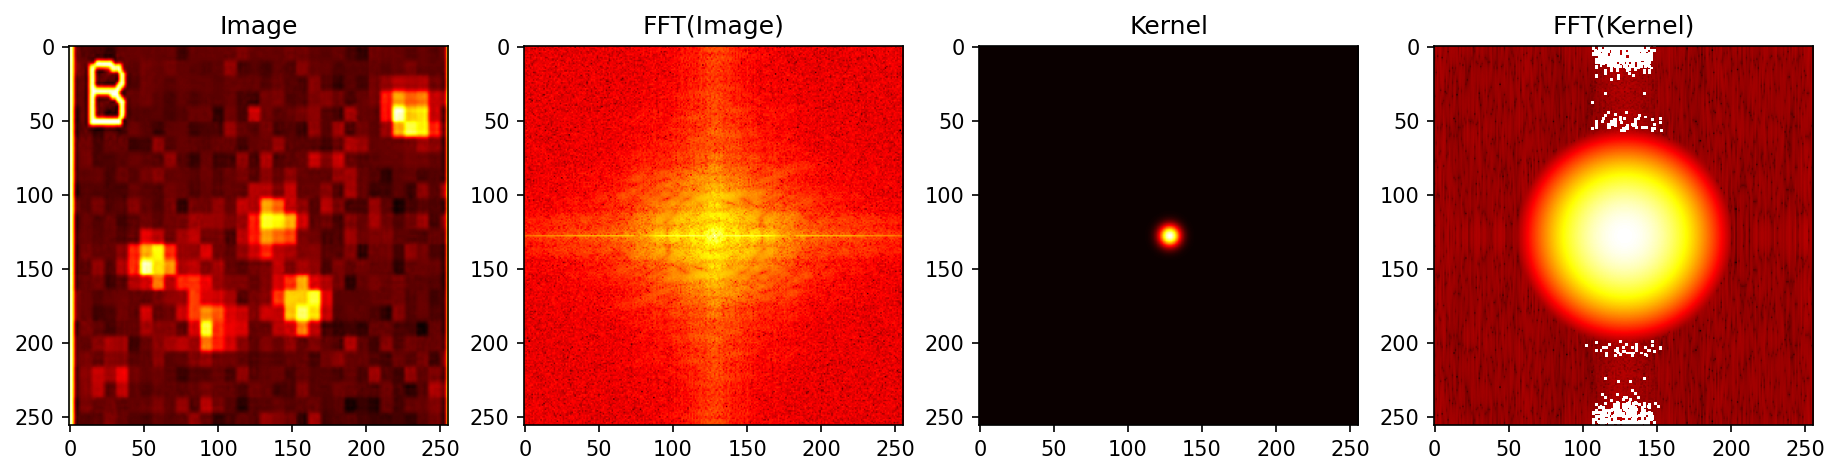

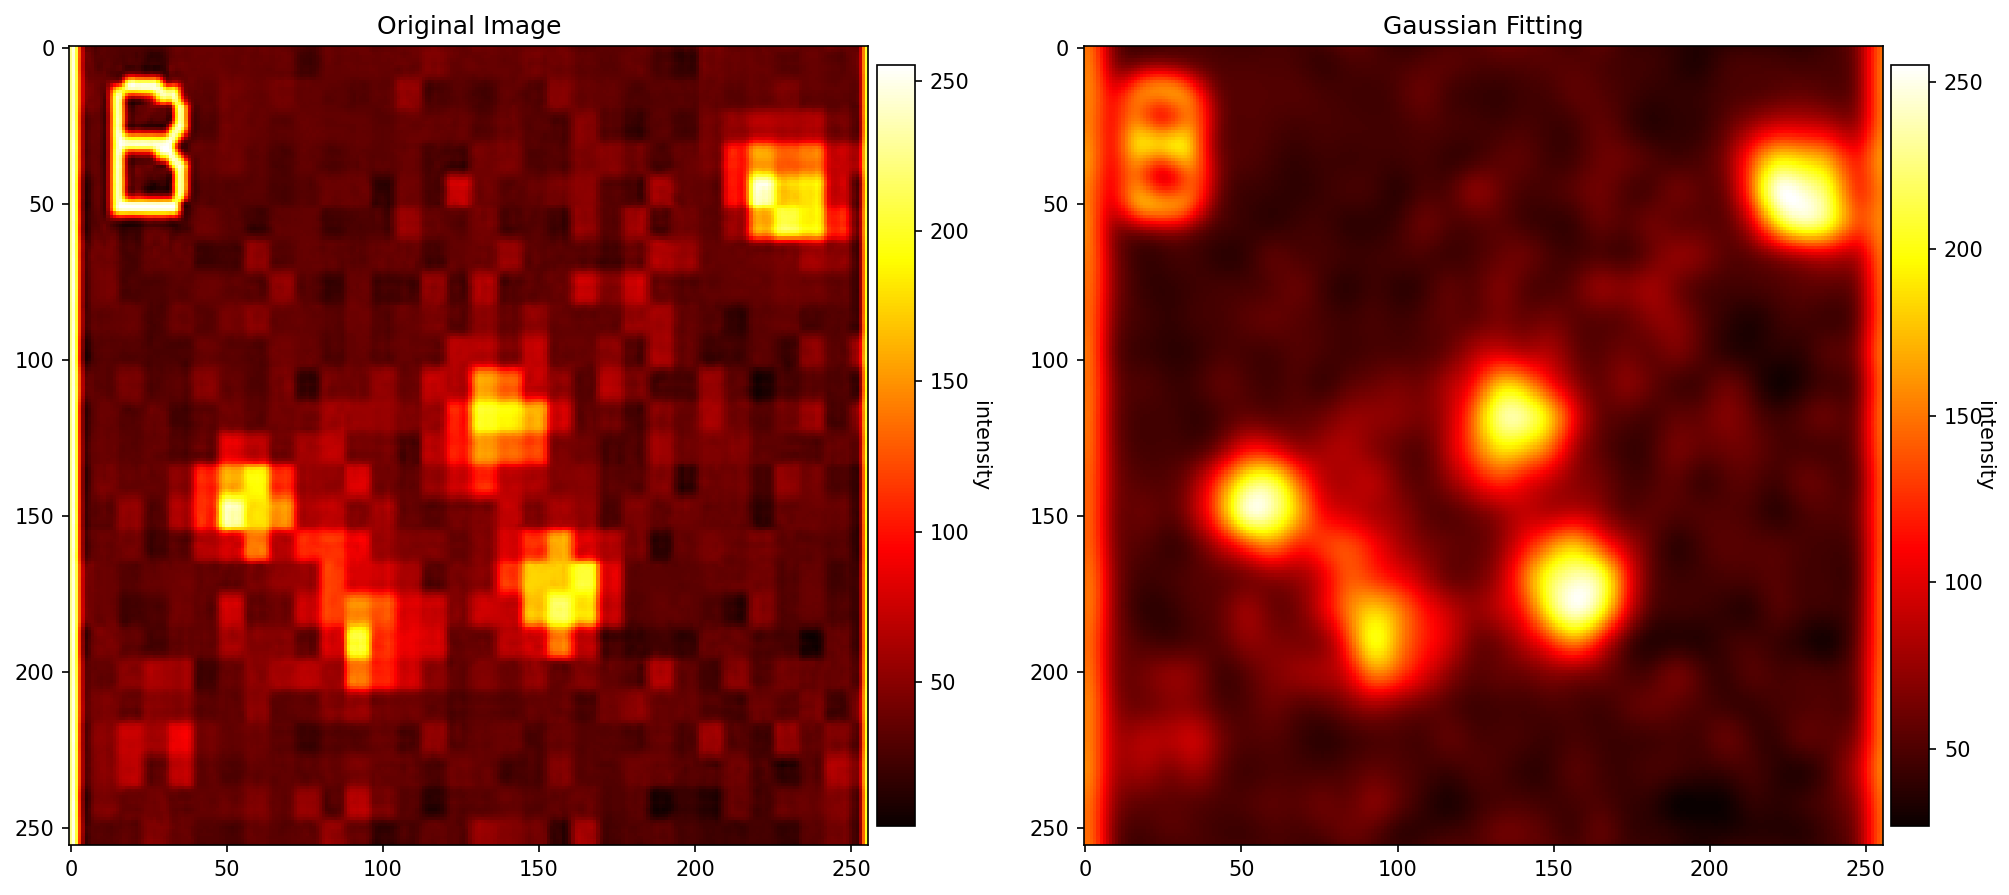

In [32]:
cmap = 'hot'

kernel = Gauss(5)

plt.figure(dpi = 150, figsize = (15,5))
plt.subplot(141)
plt.title("Image")
plt.imshow(gray_image, cmap = cmap)
plt.subplot(143)
plt.title("Kernel")
plt.imshow(kernel, cmap = cmap)
plt.subplot(142)
plt.title("FFT(Image)")

fft_img = fftshift((fft2(gray_image)))
fft_kernel = fftshift((fft2(kernel)))

plt.imshow(np.log(abs(fft_img)), cmap = cmap)
plt.subplot(144)
plt.title("FFT(Kernel)")
plt.imshow(np.log(abs(fft_kernel)), cmap = cmap)


plt.figure(dpi = 150, figsize = (16,8))
correlation = fft_img*np.conj(fft_kernel)
superresolved = abs(fftshift((ifft2(correlation))))
superresolved =255*(superresolved/np.amax(superresolved))

plt.subplot(121)
plt.title("Original Image")
img1 = plt.imshow(gray_image, cmap = cmap)
cbar1 = plt.colorbar(img1, fraction=0.045, pad=0.01)
cbar1.set_label('intensity', rotation=270, labelpad=10)
plt.subplot(122)
plt.title("Gaussian Fitting")
img2 = plt.imshow(superresolved, cmap = cmap)
cbar2 = plt.colorbar(img2, fraction=0.045, pad=0.01)
cbar2.set_label('intensity', rotation=270, labelpad=5)
# plt.colorbar()

# plt.subplot(133)
# plt.title("Deconvolved Image via FFT")
# plt.imshow(f_xy, cmap = cmap)

In [47]:
def FFT_correlation(gray_image, kernel):
    fft_img = fftshift((fft2(gray_image)))
    fft_kernel = fftshift((fft2(kernel)))
    correlation = fft_img*np.conj(fft_kernel)
    superresolved = abs(fftshift((ifft2(correlation))))
    superresolved = 255*(superresolved/np.amax(superresolved))
    return superresolved

## Kernel Size effects

### Defocus

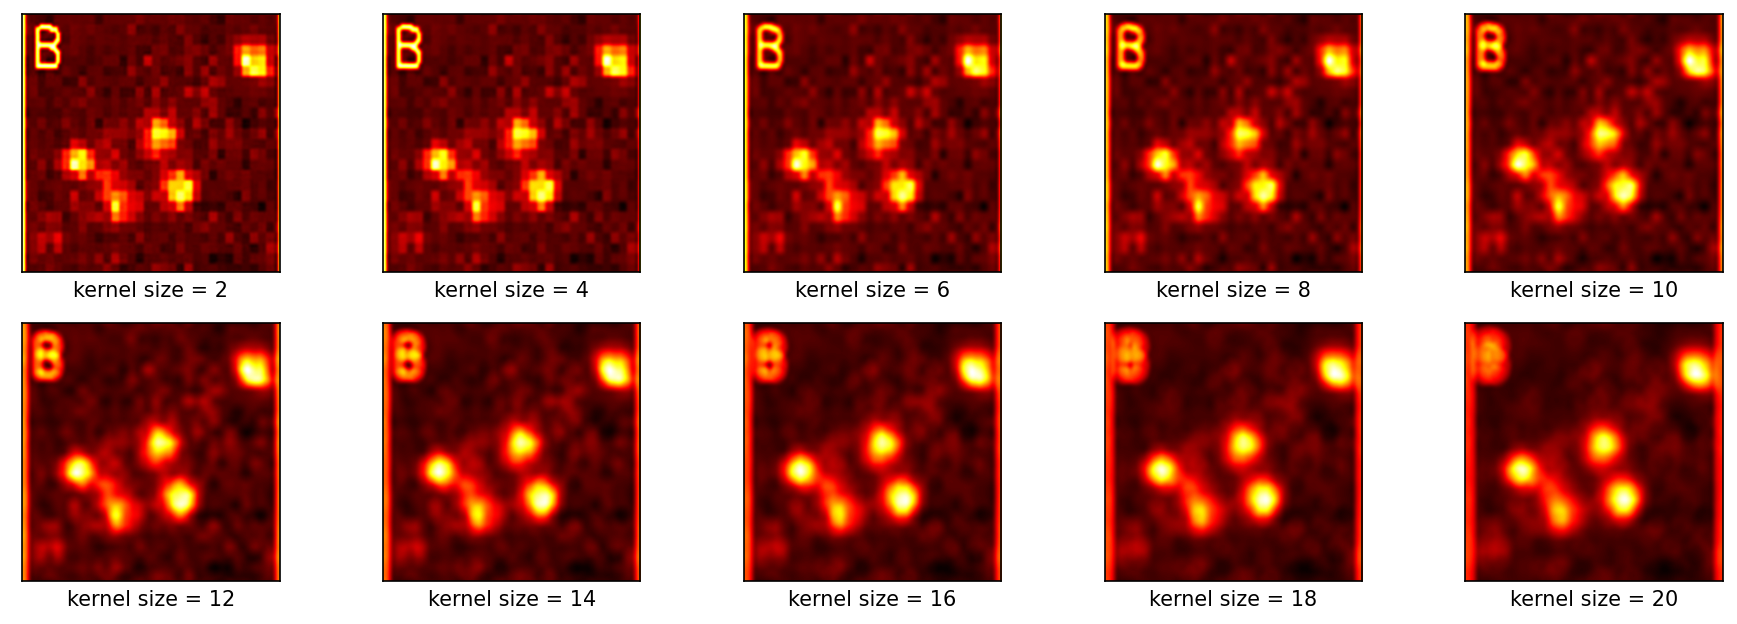

In [48]:
plt.figure(dpi = 150, figsize = (15,5))

for i in range(1,11):
    
    kernel = defocus_kernel(2*(i), sz=size)

    superresolved = FFT_correlation(gray_image, kernel)
        
    plt.subplot(2,5,i)
    plt.imshow(superresolved, cmap = cmap)
    plt.xlabel("kernel size = " + str(2*i))
    plt.xticks([])
    plt.yticks([])

### Threshholding

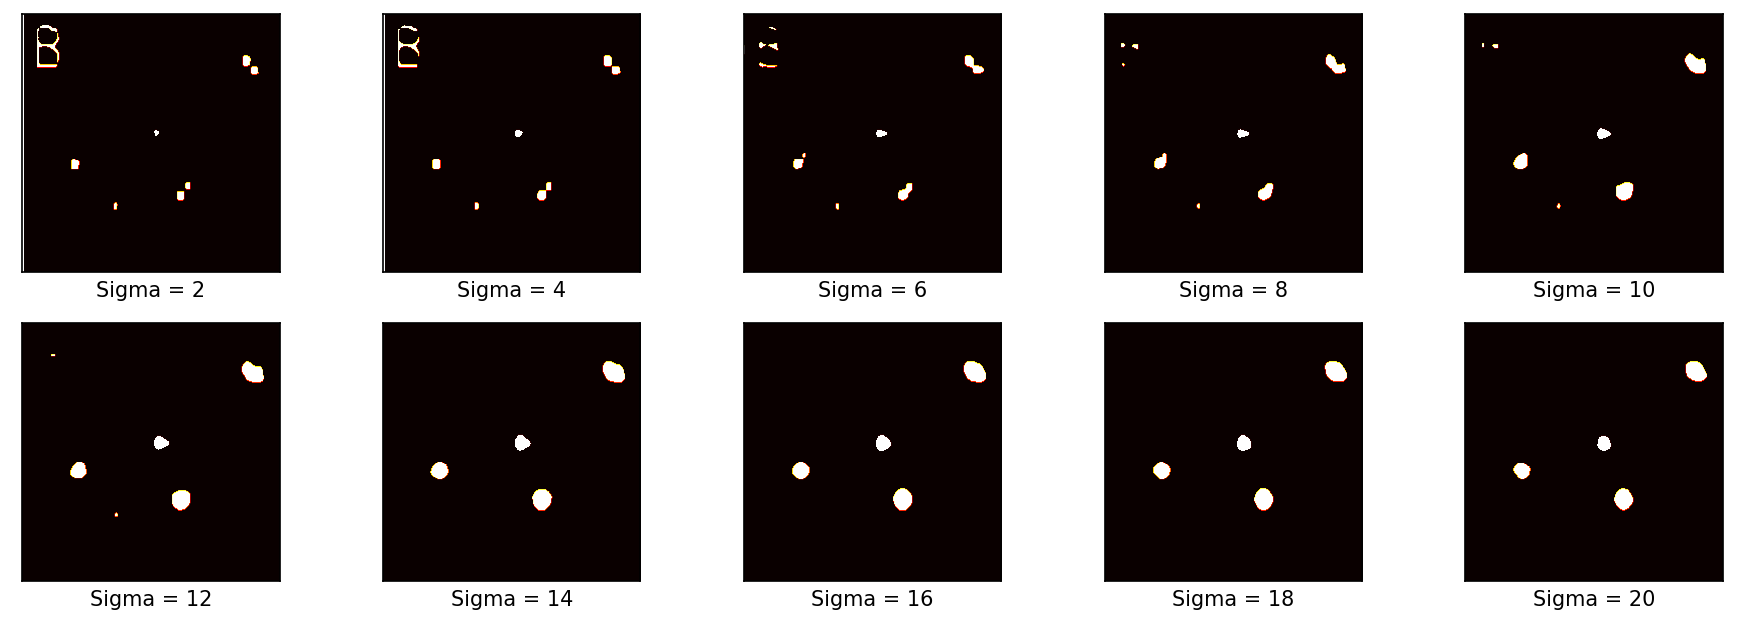

In [53]:
plt.figure(dpi = 150, figsize = (15,5))
for i in range(1,11):
    
    kernel = defocus_kernel(2*(i), sz=size)

    superresolved = FFT_correlation(gray_image, kernel)
    ret, thresh = cv2.threshold(superresolved, 200, 255, cv2.THRESH_BINARY)

    plt.subplot(2,5,i)
    plt.imshow(thresh, cmap = cmap)
    plt.xlabel("Sigma = " + str(2*i))
    plt.xticks([])
    plt.yticks([])

### Gaussian

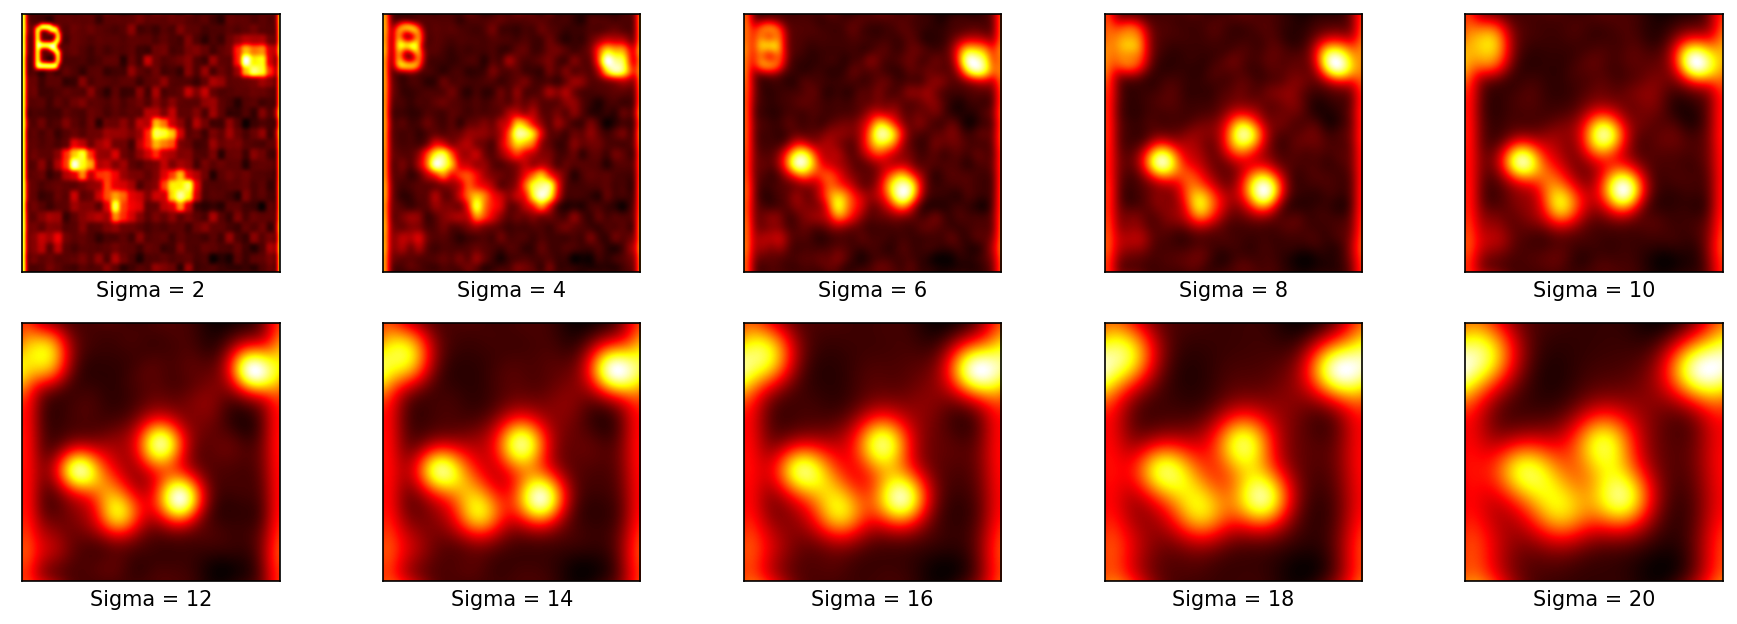

In [56]:
plt.figure(dpi = 150, figsize = (15,5))

for i in range(1,11):
    
    kernel = Gauss(2*i)

    superresolved = FFT_correlation(gray_image, kernel)

    plt.subplot(2,5,i)
    plt.imshow(superresolved, cmap = cmap)
    plt.xlabel("Sigma = " + str(2*i))
    plt.xticks([])
    plt.yticks([])

### Threshholding

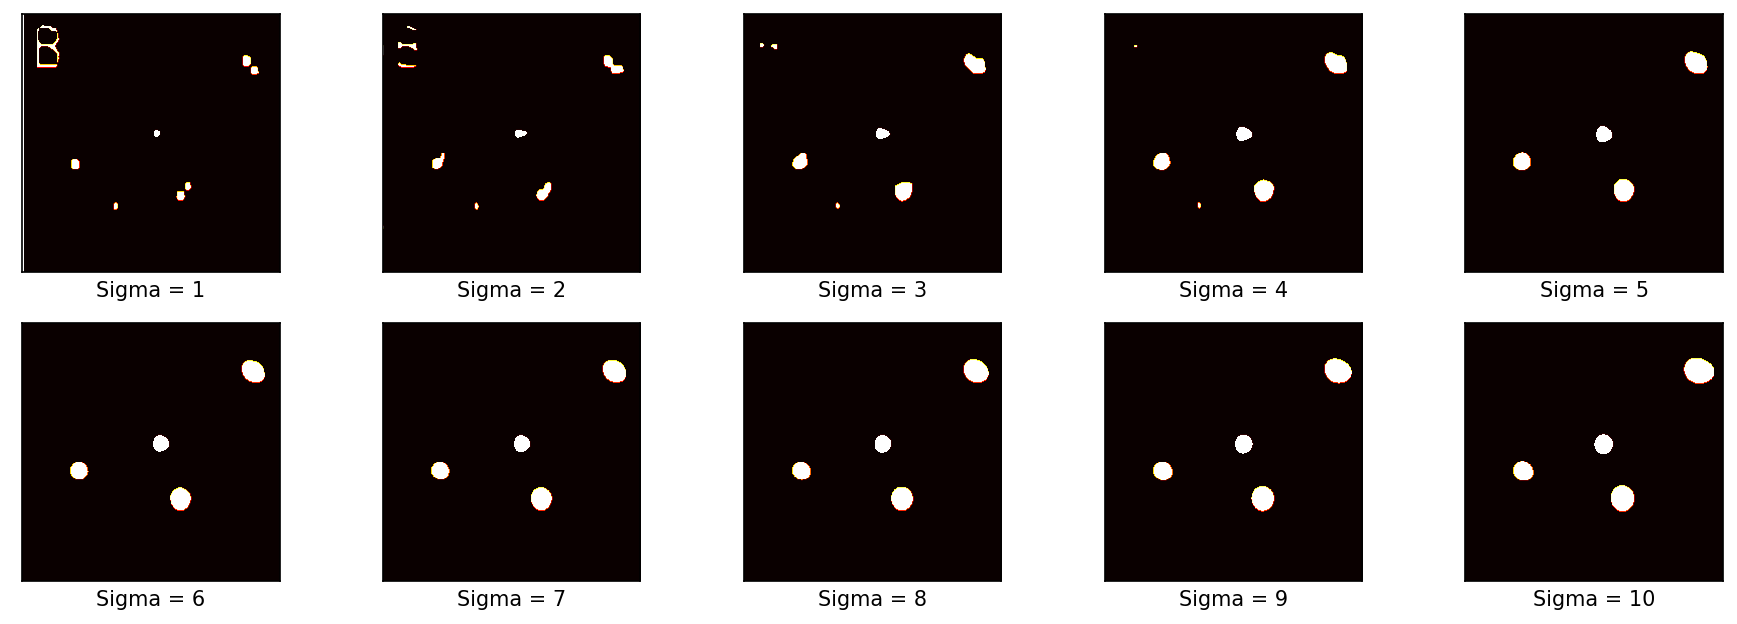

In [54]:
plt.figure(dpi = 150, figsize = (15,5))
for i in range(1,11):
    
    kernel = Gauss(i)

    superresolved = FFT_correlation(gray_image, kernel)
    ret, thresh = cv2.threshold(superresolved, 200, 255, cv2.THRESH_BINARY)

    plt.subplot(2,5,i)
    plt.imshow(thresh, cmap = cmap)
    plt.xlabel("Sigma = " + str(i))
    plt.xticks([])
    plt.yticks([])

## Centroid Mapping

### via FFT Correlation

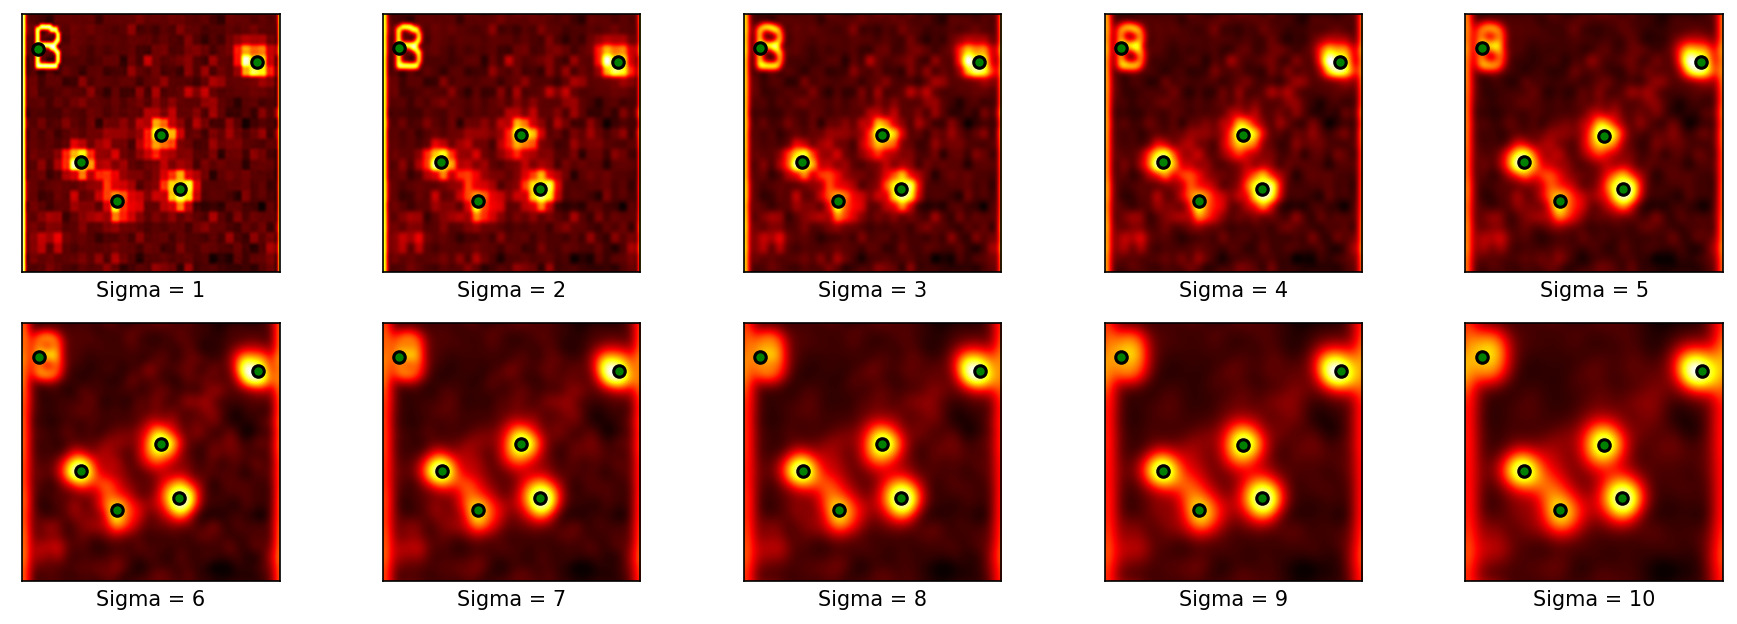

In [89]:
from scipy import ndimage

plt.figure(dpi = 150, figsize = (15,5))
for i in range(1,11):
    
    kernel = Gauss(i)
    superresolved = FFT_correlation(gray_image, kernel)
    
    plt.subplot(2,5,i)
    labeled_image, num_labels = ndimage.label(thresh)
    c_x, c_y = [], []
    for label in range(1, num_labels+1):
        mask = np.zeros_like(superresolved)
        mask[labeled_image == label] = 1
        center = ndimage.measurements.center_of_mass(superresolved * mask)
        c_y.append(center[0])
        c_x.append(center[1])
        
    plt.imshow(superresolved, cmap = cmap)
#     plt.colorbar()
    plt.xlabel("Sigma = " + str(i))
    plt.xticks([])
    plt.yticks([])

    for i in range(len(c_x)): plt.plot(c_x[i], c_y[i], 'ko')
    for i in range(len(c_x)): plt.plot(c_x[i], c_y[i], 'g.')


### with threshholding

#### Threshold = 150

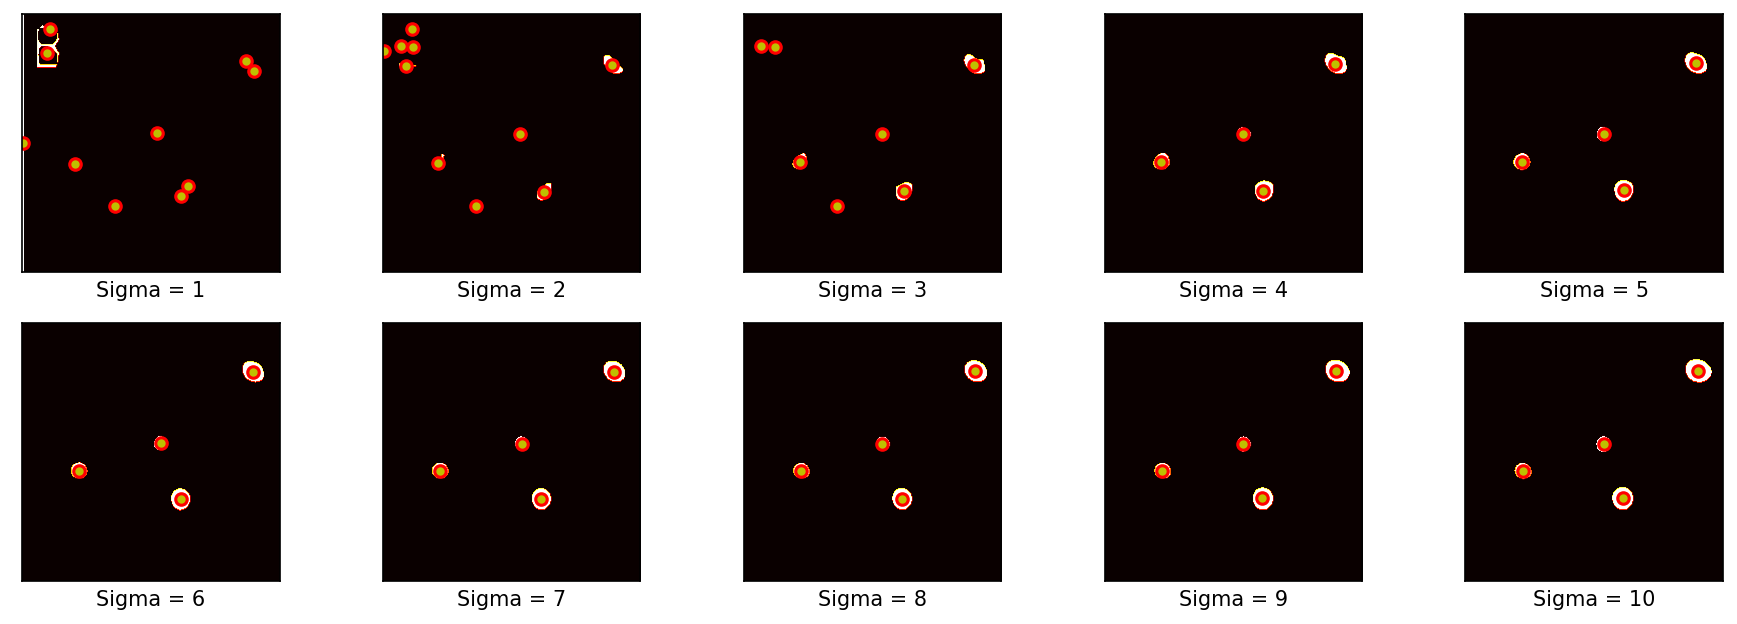

In [91]:
from scipy import ndimage

plt.figure(dpi = 150, figsize = (15,5))
for i in range(1,11):
    
    kernel = Gauss(i)
    superresolved = FFT_correlation(gray_image, kernel)
    image_8bit = cv2.normalize(superresolved, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    ret, thresh = cv2.threshold(image_8bit, 150, 255, cv2.THRESH_BINARY)
    
    plt.subplot(2,5,i)
    labeled_image, num_labels = ndimage.label(thresh)
    c_x, c_y = [], []
    for label in range(1, num_labels+1):
        mask = np.zeros_like(thresh)
        mask[labeled_image == label] = 1
        center = ndimage.measurements.center_of_mass(thresh * mask)
        c_y.append(center[0])
        c_x.append(center[1])
        
    plt.imshow(thresh, cmap = cmap)
    plt.xlabel("Sigma = " + str(i))
    plt.xticks([])
    plt.yticks([])

    for i in range(len(c_x)): plt.plot(c_x[i], c_y[i], 'ro')
    for i in range(len(c_x)): plt.plot(c_x[i], c_y[i], 'y.')

#### Threshold = 200

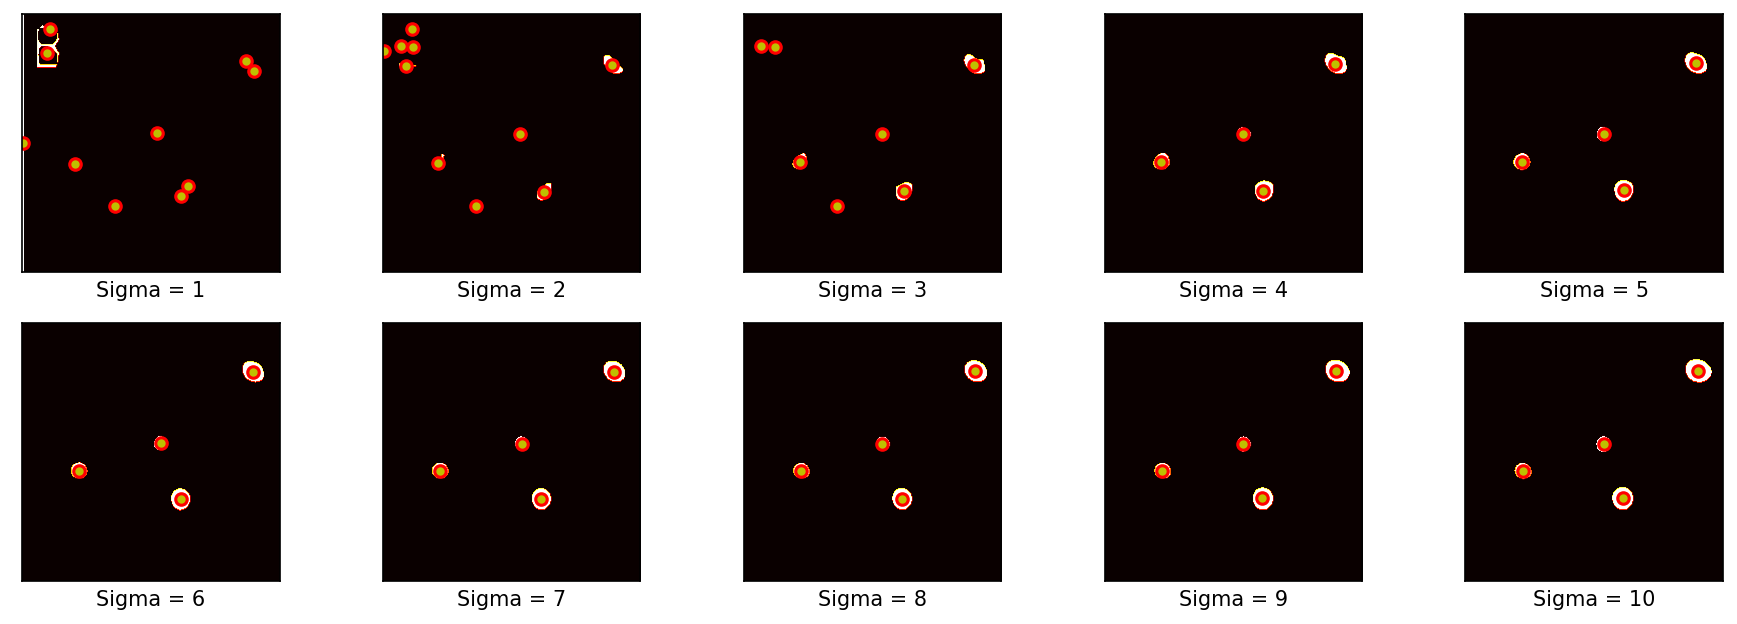

In [92]:
from scipy import ndimage

plt.figure(dpi = 150, figsize = (15,5))
for i in range(1,11):
    
    kernel = Gauss(i)
    superresolved = FFT_correlation(gray_image, kernel)
    image_8bit = cv2.normalize(superresolved, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    ret, thresh = cv2.threshold(image_8bit, 200, 255, cv2.THRESH_BINARY)
    
    plt.subplot(2,5,i)
    labeled_image, num_labels = ndimage.label(thresh)
    c_x, c_y = [], []
    for label in range(1, num_labels+1):
        mask = np.zeros_like(thresh)
        mask[labeled_image == label] = 1
        center = ndimage.measurements.center_of_mass(thresh * mask)
        c_y.append(center[0])
        c_x.append(center[1])
        
    plt.imshow(thresh, cmap = cmap)
    plt.xlabel("Sigma = " + str(i))
    plt.xticks([])
    plt.yticks([])

    for i in range(len(c_x)): plt.plot(c_x[i], c_y[i], 'ro')
    for i in range(len(c_x)): plt.plot(c_x[i], c_y[i], 'y.')

# Skimage Peak Local Maximum

## varying the panning window

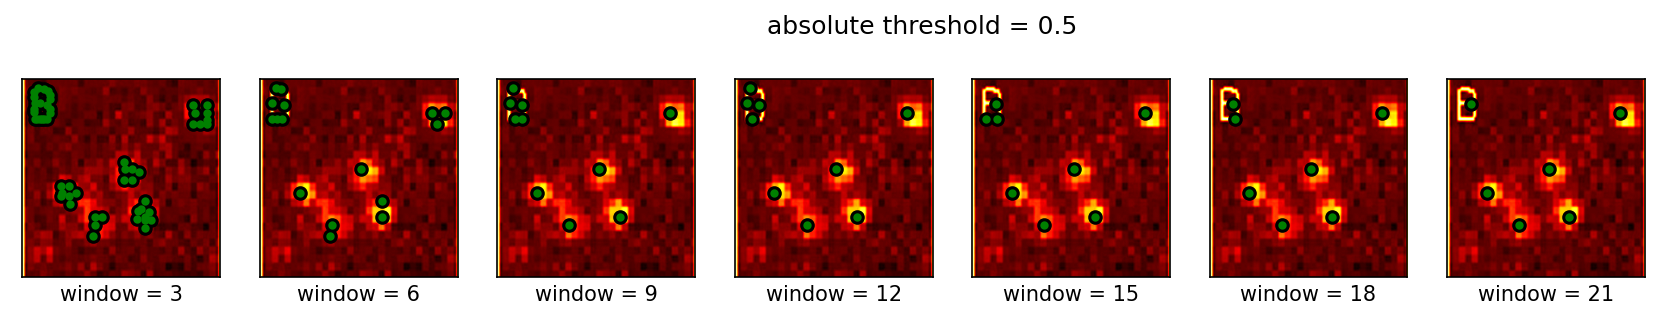

In [148]:
IMG = gray_image/np.amax(gray_image)

plt.figure(dpi = 150, figsize = (16,4))
for i in range(1,8):
    
    peaks = peak_local_max(IMG, min_distance=i*3, threshold_abs=0.5)
    plt.suptitle("absolute threshold = 0.5")
    plt.subplot(2,8,i)
    plt.imshow(IMG, cmap = cmap)
    plt.xlabel("window = " + str(i*3))
    for i in range(len(peaks)): plt.plot(peaks[i,1], peaks[i,0], 'ko')
    for i in range(len(peaks)): plt.plot(peaks[i,1], peaks[i,0], 'g.')
    plt.xticks([])
    plt.yticks([])


## varying the threshold value

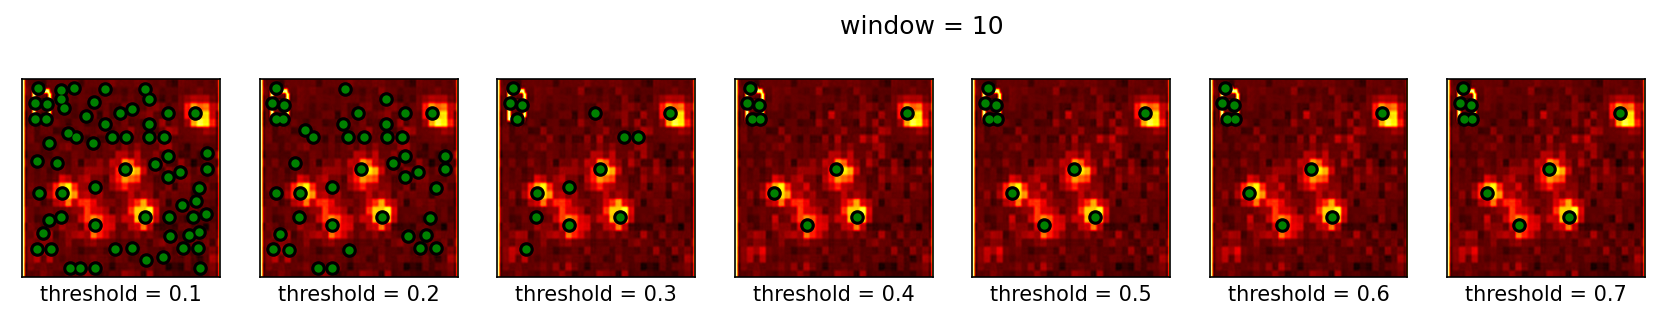

In [149]:

plt.figure(dpi = 150, figsize = (16,4))
for i in range(1,8):
    
    peaks = peak_local_max(IMG, min_distance=10, threshold_abs=0.1*i)
    plt.suptitle("window = 10")
    plt.subplot(2,8,i)
    plt.imshow(IMG, cmap = cmap)
    plt.xlabel("threshold = " + str(np.round(i*0.1, 3)))
    for i in range(len(peaks)): plt.plot(peaks[i,1], peaks[i,0], 'ko')
    for i in range(len(peaks)): plt.plot(peaks[i,1], peaks[i,0], 'g.')
    plt.xticks([])
    plt.yticks([])

# Gaussian Mixture Model

In [151]:
from sklearn.mixture import GaussianMixture
from skimage import io

In [152]:
image = io.imread("Picture1.png", as_gray=True)
pixels = image.ravel()

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  6.23it/s]


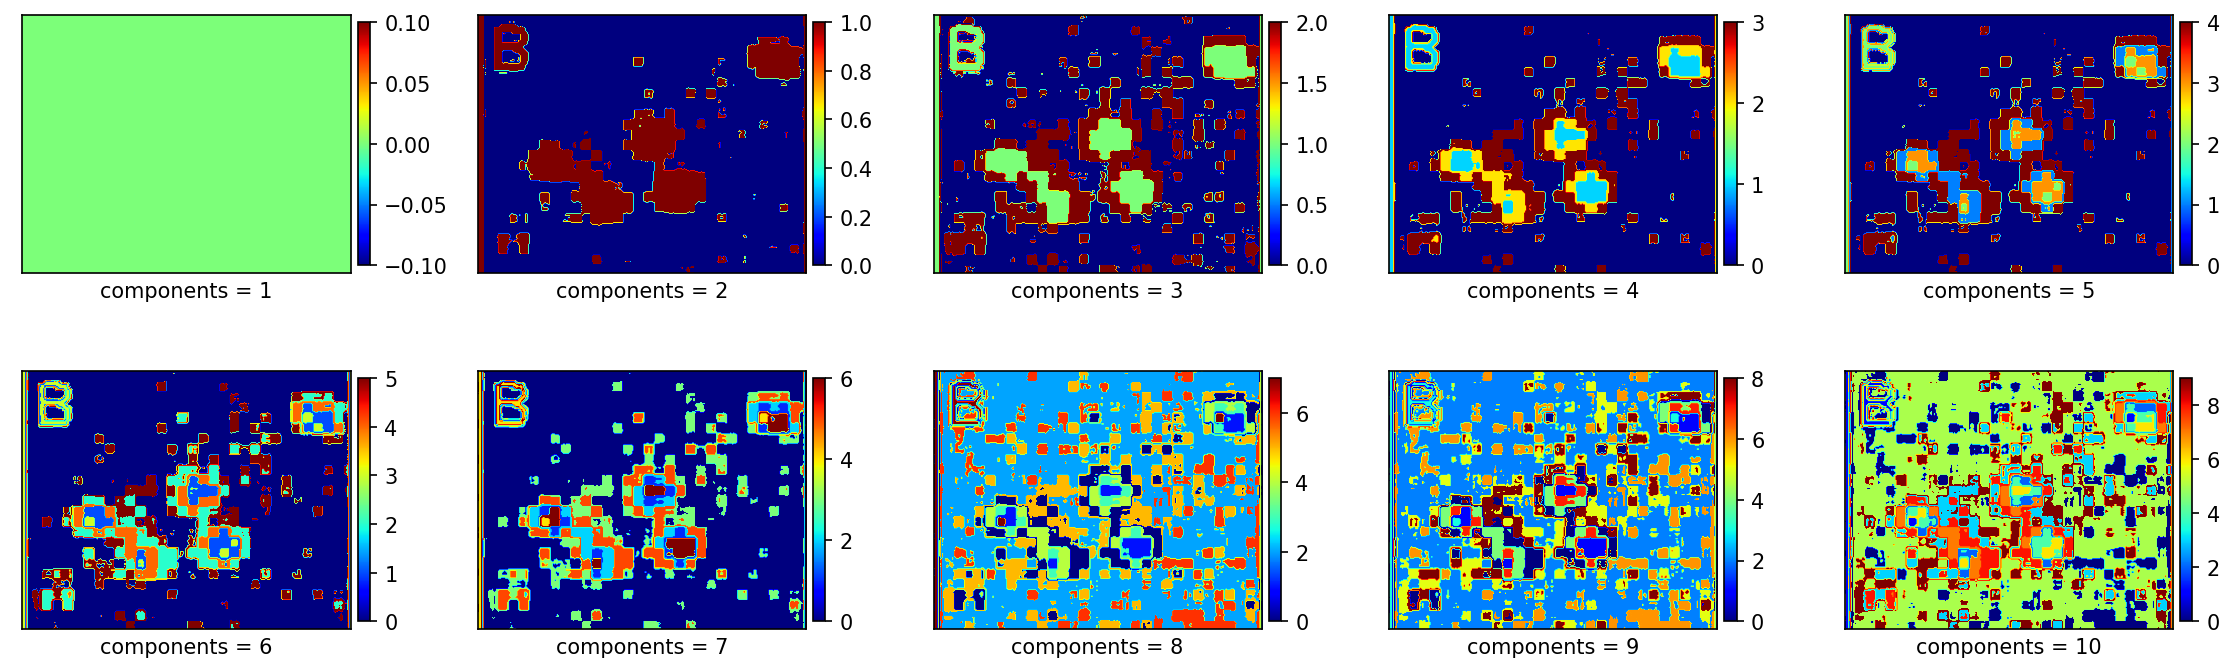

In [156]:
plt.figure(dpi = 150, figsize = (15,5))

for i in tqdm(range(1,11)):
    n_components = i
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(pixels.reshape(-1, 1))
    labels = gmm.predict(pixels.reshape(-1, 1))
    segmented_image = labels.reshape(image.shape)

    plt.subplot(2,5,i)
    img = plt.imshow(segmented_image, cmap = 'jet')
    plt.xlabel("components = " + str(i))
    cbar = plt.colorbar(img, fraction=0.035, pad=0.02)
#     cbar.set_label('intensity', rotation=270, labelpad=5)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()